## Finding the 3 important variable in predicting demand for shared bikes

In [141]:
#importing the required packages
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgboost


from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

## Reading the data

In [142]:
df=pd.read_csv("D:\python\day - day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [143]:
#checking the size of the dataset
shape=df.shape
print("There are",shape[1],"columns and",shape[0],"records in the dataset")

There are 16 columns and 730 records in the dataset


In [144]:
#viewing the column names
columns=df.columns
columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

## Cleaning and processing the data

In [145]:
#finding the null values
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [146]:
#viewing duplicate values
df.duplicated().sum()

0

In [147]:
#viewing the datatypes
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [148]:
#changing the "dteday" column's data type from object to datetime
df["dteday"]=pd.to_datetime(df["dteday"])

In [149]:
#viweing the STATISTICAL information of the dataset
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


CHECKING FOR OUTLIERS

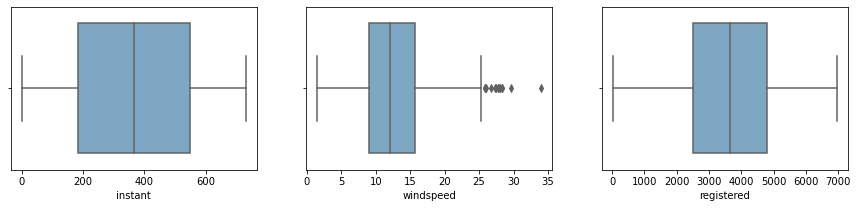

In [150]:
fig,axis=plt.subplots(1,3,figsize=(15,3))
sns.boxplot(df["instant"],palette="PuBu",ax=axis[0])
sns.boxplot(df["windspeed"],palette="PuBu",ax=axis[1])
sns.boxplot(df["registered"],palette="PuBu",ax=axis[2])
plt.show()

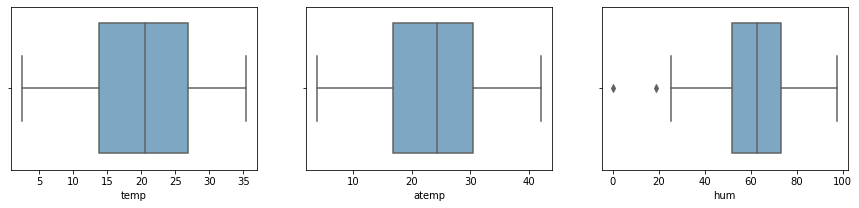

In [151]:
fig,axis=plt.subplots(1,3,figsize=(15,3))
sns.boxplot(df["temp"],palette="PuBu",ax=axis[0])
sns.boxplot(df["atemp"],palette="PuBu",ax=axis[1])
sns.boxplot(df["hum"],palette="PuBu",ax=axis[2])
plt.show()

REMOVING THE OUTLIERS

In [152]:
# removing the outlier for "windspeed"
q1=np.quantile(df["windspeed"],0.25)
q3=np.quantile(df["windspeed"],0.75)
iqr=q3-q1
low=q1-1.5*iqr
high=q3+1.5*iqr

In [153]:
# df["windspeed"]=df["windspeed"].clip(low,high)

In [154]:
# removing the outlier for "hum"
q1=np.quantile(df["hum"],0.25)
q3=np.quantile(df["hum"],0.75)
iqr=q3-q1
low=q1-1.5*iqr
high=q3+1.5*iqr

In [155]:
# df["hum"]=df["hum"].clip(low,high)

## Splitting the data

In [184]:
#splitting the data
#eliminating the unwanted features
x=df.drop(columns=["instant","dteday","cnt","casual","registered"])
y=df["cnt"]

In [185]:
#spltting it to tranning and testing data
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=7,test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(584, 11)
(146, 11)
(584,)
(146,)


## Model fitting

In [186]:
#scaling the data for using knn
scaler=StandardScaler()
scaler.fit(x_train)

x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [187]:
#BUILDING KNN MODEL
knn=KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [188]:
#EVALUATION METRICS
y_pred_knn=knn.predict(x_test)
score_knn=r2_score(y_test,y_pred_knn)
score_knn

0.7649166154781186

In [189]:
#tunning for the best hyperparameter(k)  value
iteration_knn=[]
cross_vals_knn_ht=[]
for i in range(3,21):
    knn_ht=KNeighborsRegressor(n_neighbors=i)
    knn_ht.fit(x_train,y_train)
    y_pred_knn_ht=knn_ht.predict(x_test)
    cross_score_knn_ht=np.mean(cross_val_score(knn_ht,x_train,y_train,cv=10))
    cross_vals_knn_ht.append(cross_score_knn_ht)
    iteration_knn.append(i)
knn_ht_vals=dict(zip(iteration_knn,cross_vals_knn_ht))
print(knn_ht_vals)

{3: 0.8277655903146964, 4: 0.8352228520293952, 5: 0.8416998428678244, 6: 0.8457022117714974, 7: 0.8423984788481489, 8: 0.8364053567860026, 9: 0.8304482004520874, 10: 0.8306921527979704, 11: 0.827958179975892, 12: 0.823415091502244, 13: 0.8151111724571155, 14: 0.8105928348367044, 15: 0.8045988004243135, 16: 0.8024089989635736, 17: 0.8001105446916267, 18: 0.7974722147787556, 19: 0.7991238669030406, 20: 0.8012749631698295}


In [190]:
max_knnval_score=max(knn_ht_vals.values())
position=list(knn_ht_vals.values()).index(max_knnval_score)
ht_value=list(knn_ht_vals.keys())
print("The hyper tuned k value with high validation score is:",ht_value[position],"with the validation score:",max_knnval_score)

The hyper tuned k value with high validation score is: 6 with the validation score: 0.8457022117714974


In [191]:
knn=KNeighborsRegressor(n_neighbors=ht_value[position])
knn.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=6)

In [192]:
y_pred_knn=knn.predict(x_test)
score_knn=r2_score(y_test,y_pred_knn)
score_knn

0.7629876354943511

In [193]:
#BUILDING THE DESCION TREE MODEL
dtm=DecisionTreeRegressor(max_depth=2)
dtm.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=2)

In [194]:
pred_y_dtm=dtm.predict(x_test)
score_dtm=r2_score(y_test,pred_y_dtm)
score_dtm

0.6383661997419219

In [195]:
#using cross validation finding the best hyperparamter (max_depth) value
cross_scores_dept=[]
iteration=[]
for i in [3,4,5,6,7,8,9,10,20,40]:
    dt_max_depth=DecisionTreeRegressor(max_depth=i)
    dt_max_depth.fit(x_train,y_train)
    cross_score_dt_ht=cross_val_score(dt_max_depth,x,y,cv=10)
    cross_scores_dept.append(np.mean(cross_score_dt_ht))
    iteration.append(i)
    
max_dept_i=dict(zip(iteration,cross_scores_dept))
print(max_dept_i)
    

{3: -1.0281469782862396, 4: -0.6702144485972114, 5: -0.8017981547685166, 6: -0.9432963204829992, 7: -0.7910178724552261, 8: -0.8484171976515986, 9: -0.8228602786048823, 10: -0.8369884979796355, 20: -0.8453434074439393, 40: -0.8758550300174631}


In [196]:
#taking the max_val_cross's depth_value
max_score=max(max_dept_i.values())
position=list(max_dept_i.values()).index(max_score)
apt_dept_value=list(max_dept_i.keys())
print("The hyper tunned depth_value with high val_score is:",apt_dept_value[position],"with the val score:",max_score)

The hyper tunned depth_value with high val_score is: 4 with the val score: -0.6702144485972114


In [197]:
#building descion tree model with depth value 10
dt=DecisionTreeRegressor(max_depth=apt_dept_value[position])
dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=4)

In [198]:
pred_y_dt=dt.predict(x_test)
score_dt=r2_score(y_test,pred_y_dt)
score_dt

0.7046553404421516

In [199]:
#building random forest model
# max_dept=log2(number of features)
dept=round(math.log2(len(x_train)))
rf=RandomForestRegressor(n_estimators=50,max_depth=dept,max_features="sqrt")
rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=50)

In [200]:
y_pred_rf=rf.predict(x_test)
score_rf=r2_score(y_test,y_pred_rf)
score_rf

0.8268295452196661

In [201]:
#building xgboost model
xgm=xgboost.XGBRegressor(max_depth=dept,learning_rate=0.03,n_estimator=100,verbosity=0)
xgm.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimator=100,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [202]:
y_pred_xgm=xgm.predict(x_test)
score_xgm=r2_score(y_test,y_pred_xgm)
score_xgm

0.8126525196562457

In [203]:
#tunning the hyper parameter(learning rate)
cross_vals_xg_ht=[]
iteration=[]
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
    xg_ht=xgboost.XGBRegressor(max_depth=dept,learning_rate=i,n_estimator=100,verbosity=0)
    xg_ht.fit(x_train,y_train)
    cross_score_xg_ht=np.mean(cross_val_score(xg_ht,x_train,y_train,cv=10))
    cross_vals_xg_ht.append(cross_score_xg_ht)
    iteration.append(i)
xg_ht_vals=dict(zip(iteration,cross_vals_xg_ht))
print(xg_ht_vals)

{0.01: -0.06001092248843587, 0.02: 0.7247463711802181, 0.03: 0.8423703004782578, 0.04: 0.8659543161830913, 0.05: 0.8718557397944096, 0.06: 0.8703010760742711, 0.07: 0.8737149906178544, 0.08: 0.8755296005615536, 0.09: 0.869259088283101, 0.1: 0.8691922786715403}


In [204]:
max_xgval_score=max(xg_ht_vals.values())
position=list(xg_ht_vals.values()).index(max_xgval_score)
ht_value=list(xg_ht_vals.keys())
print("The hyper tuned learing_rate value with high validation score is:",ht_value[position],"with the validation score:",max_xgval_score)

The hyper tuned learing_rate value with high validation score is: 0.08 with the validation score: 0.8755296005615536


In [205]:
#building xgboost model with the tunned hyperparameter (learning_rate=0.07)
xgb=xgboost.XGBRegressor(max_depth=dept,learning_rate=0.09,n_estimator=100,verbosity=0)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.09, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimator=100,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [206]:
y_pred_xgb=xgb.predict(x_test)
score_xgb=r2_score(y_test,y_pred_xgb)
score_xgb

0.8465397685622209

## Choosing the best model using cross validation

In [207]:
cross_score_lin=cross_val_score(knn,x_train,y_train,cv=10).mean()
cross_score_dt=cross_val_score(dt,x_train,y_train,cv=10).mean()
cross_score_rf=cross_val_score(rf,x_train,y_train,cv=10).mean()
cross_score_xg=cross_val_score(xgb,x_train,y_train,cv=10).mean()

In [208]:
print("Cross value score of linear regression model is:",cross_score_lin)
print("Cross value score of descision tree model is:",cross_score_dt)
print("Cross value score of random forest model is:",cross_score_rf)
print("Cross value score of extreme gradient boosting  model is:",cross_score_xg)

Cross value score of linear regression model is: 0.8457022117714974
Cross value score of descision tree model is: 0.8005047185455716
Cross value score of random forest model is: 0.8765034844373977
Cross value score of extreme gradient boosting  model is: 0.869259088283101


In [209]:
#getting the maximum validation score
max_score=max([cross_score_lin,cross_score_dt,cross_score_rf,cross_score_xg])
print("The maximum validation score out of all model is",max_score,"which belongs to RANDOM FOREST MODEL MODEL")

The maximum validation score out of all model is 0.8765034844373977 which belongs to RANDOM FOREST MODEL MODEL


## Finding the important variable

In [210]:
#As randomforest is the best model out of all,getting the features in that model
important_features=dict(zip(x.columns,rf.feature_importances_))
for i in important_features:
    print("The variable value of",i,"is",important_features[i])

The variable value of season is 0.1174074107033102
The variable value of yr is 0.2666861918342112
The variable value of mnth is 0.09203867015217873
The variable value of holiday is 0.002865081139678669
The variable value of weekday is 0.013392813122799548
The variable value of workingday is 0.003813553678307375
The variable value of weathersit is 0.026074062057233588
The variable value of temp is 0.17674531623216685
The variable value of atemp is 0.18784183679804356
The variable value of hum is 0.06672335154699502
The variable value of windspeed is 0.04641171273507527


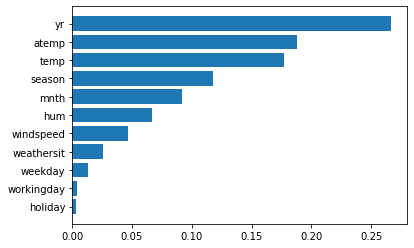

In [211]:
#visualizing the important features
sorted_idx=rf.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx],rf.feature_importances_[sorted_idx]);

by seeing the graph we can say that yr,atemp,temp,season,mnth are some of the important variables, but yr doesnt makes sense and does not play a important role in predicting the future,so we are eliminating the varaiable "yr".

## So we can infer that the variables temp, atemp and season are the 3 important variable in predicting demand for shared bikes.